Exploratory Data Analysis

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import pearsonr
#windroses
from windrose import WindroseAxes
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,font_scale=1.5)

In [2]:
picadilly = pd.read_csv('./MCC_combined.csv',header=0, index_col=0)
sharston = pd.read_csv('./sharston_combined.csv',header=0,index_col=0)

In [3]:
#append columns withsite label for plotting
picadilly['siteID'] = np.repeat('Piccadilly',picadilly.shape[0])
sharston['siteID'] = np.repeat('Sharston',sharston.shape[0])

In [4]:
column_names = ['NO2','temp','ws','wd','Volume','siteID']

In [5]:
#get 2018 and 2019 data
picadilly_values = picadilly[(picadilly.index >= '2018-01-01') & (picadilly.index <= '2019-12-31') ]
sharston_values = sharston[(sharston.index >= '2018-01-01') & (sharston.index <= '2019-12-31') ]

In [6]:
print(picadilly_values.shape, sharston_values.shape)

(17496, 34) (17496, 34)


In [7]:
picadilly_values = picadilly_values[column_names].values
sharston_values = sharston_values[column_names].values

In [8]:
print(picadilly_values.shape, sharston_values.shape)

(17496, 6) (17496, 6)


In [9]:
non_lockdown_data = pd.DataFrame(np.concatenate((picadilly_values,sharston_values),axis=0), columns=column_names)
non_lockdown_data

,NO2,temp,ws,wd,Volume,siteID
0,25.96304,3.4,3.5,225.5,137,Piccadilly
1,25.35174,3.4,4.8,222.4,180,Piccadilly
2,18.03759,3.4,4.7,223.9,135,Piccadilly
3,23.24502,3.3,4.8,225.9,98,Piccadilly
4,23.04107,3.4,5.0,230.3,86,Piccadilly
...,...,...,...,...,...,...
34987,49.63519,6.8,2.7,223.1,272,Sharston
34988,46.96902,6.9,2.5,115.9,196,Sharston
34989,50.38628,6.8,1.3,169.0,162,Sharston
34990,46.58983,6.3,1.7,166.4,169,Sharston


In [10]:
for i in column_names[:5]:
    non_lockdown_data[i] = non_lockdown_data[i].astype('int32')

non_lockdown_data['siteID'] = non_lockdown_data['siteID'].astype('category')

non_lockdown_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34992 entries, 0 to 34991
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   NO2     34992 non-null  int32   
 1   temp    34992 non-null  int32   
 2   ws      34992 non-null  int32   
 3   wd      34992 non-null  int32   
 4   Volume  34992 non-null  int32   
 5   siteID  34992 non-null  category
dtypes: category(1), int32(5)
memory usage: 717.9 KB


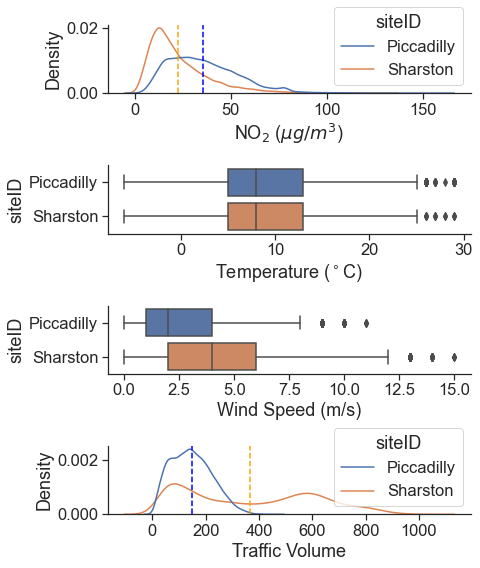

In [15]:
plt.figure(figsize=(7,8))
plt.subplot(4,1,1)
sns.kdeplot(data= non_lockdown_data, x = 'NO2',hue='siteID')
plt.axvline(np.mean( non_lockdown_data.NO2[non_lockdown_data['siteID']=='Piccadilly']), color='blue',ls='--')
plt.axvline(np.mean( non_lockdown_data.NO2[non_lockdown_data['siteID']=='Sharston']), color='orange',ls='--') 
plt.xlabel('NO${_2}$ (${\mu g/m^{3}}$)')
plt.subplot(4,1,2)
sns.boxplot(data = non_lockdown_data, y = 'siteID', x  = 'temp')
plt.xlabel('Temperature ($^\circ$C)')
plt.subplot(4,1,3)
sns.boxplot(data = non_lockdown_data, y = 'siteID', x  = 'ws')
plt.xlabel('Wind Speed (m/s)')
plt.subplot(4,1,4)
sns.kdeplot(data= non_lockdown_data, x = 'Volume',hue='siteID')
plt.axvline(np.mean( non_lockdown_data.Volume[non_lockdown_data['siteID']=='Piccadilly']), color='blue',ls='--')
plt.axvline(np.mean( non_lockdown_data.Volume[non_lockdown_data['siteID']=='Sharston']), color='orange',ls='--')
plt.xlabel('Traffic Volume')
plt.tight_layout()
plt.savefig('./FiguresEDA/Distribution_Plot.png')

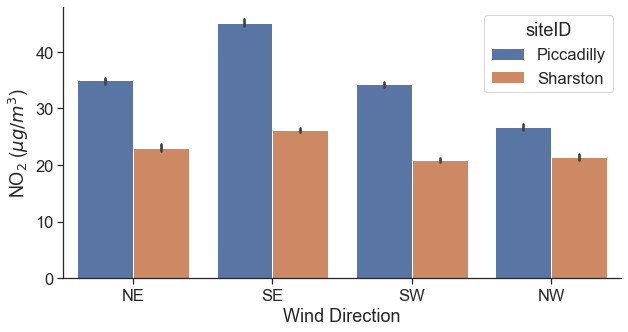

In [16]:
non_lockdown_data['wd_cat'] = pd.cut(non_lockdown_data['wd'].to_numpy(), bins = [0,90,180,270,360],right=True, labels =['NE','SE','SW','NW'])
plt.figure(figsize=(10,5))
sns.barplot(data=non_lockdown_data,x='wd_cat',y='NO2',hue='siteID')
plt.xlabel('Wind Direction')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)')
plt.savefig('./FiguresEDA/NO2vsWindDirection')
# wind_direction = wind_direction.set_index(df.index)

In [17]:
# non_lockdown_data['wd_cat'] = pd.cut(non_lockdown_data['wd'].to_numpy(), bins = [0,45,90,135,180,225,270,315,360],right=True, labels =['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW'])
# sns.barplot(data=non_lockdown_data,x='wd_cat',y='NO2',hue='siteID')
# # wind_direction = wind_direction.set_index(df.index)

In [18]:
df = pd.get_dummies(non_lockdown_data[['wd_cat']])
df.columns = ['NE','SE','SW','NW']
corr_data = non_lockdown_data.drop(['wd','wd_cat'],axis=1).merge(df,on=None, left_index=True,right_index=True)

In [19]:
corr_data

,NO2,temp,ws,Volume,siteID,NE,SE,SW,NW
0,25,3,3,137,Piccadilly,0,0,1,0
1,25,3,4,180,Piccadilly,0,0,1,0
2,18,3,4,135,Piccadilly,0,0,1,0
3,23,3,4,98,Piccadilly,0,0,1,0
4,23,3,5,86,Piccadilly,0,0,1,0
...,...,...,...,...,...,...,...,...,...
34987,49,6,2,272,Sharston,0,0,1,0
34988,46,6,2,196,Sharston,0,1,0,0
34989,50,6,1,162,Sharston,0,1,0,0
34990,46,6,1,169,Sharston,0,1,0,0


In [20]:
pic = corr_data[corr_data['siteID']=='Piccadilly'].corr()[['NO2']].iloc[1:,:]
pic.columns = ['Picadilly']#.reindex(pic.NO2.abs().sort_values(ascending=False).index)

In [21]:
shar = corr_data[corr_data['siteID']=='Sharston'].corr()[['NO2']].iloc[1:,:]
shar.columns  = ['Sharston']#.reindex(shar.NO2.abs().sort_values(ascending=False).index)
nld_corr_comparison = shar.merge(pic,on=None, left_index=True,right_index=True)

In [22]:
pic_ld = picadilly[picadilly['Lockdown']==1][['NO2', 'temp', 'ws', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume',]].reset_index(drop=True)
pic_ld.columns = ['NO2', 'temp', 'ws', 'NE', 'SE', 'SW', 'NW', 'Volume']
shar_ld = sharston[sharston['Lockdown']==1][['NO2', 'temp', 'ws', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume',]].reset_index(drop=True)
shar_ld.columns = ['NO2', 'temp', 'ws', 'NE', 'SE', 'SW', 'NW', 'Volume']

In [23]:
all_data = pd.DataFrame(np.concatenate((picadilly.values,sharston.values),axis=0),columns=picadilly.columns)
all_data['Wind Direction'] = pd.cut(all_data['wd'].to_numpy(), bins = [0,90,180,270,360],right=True, labels =['NE','SE','SW','NW'])
all_data['Lockdown'] = all_data['Lockdown'].replace({1:'Yes',0:'No'})

<Figure size 720x360 with 0 Axes>

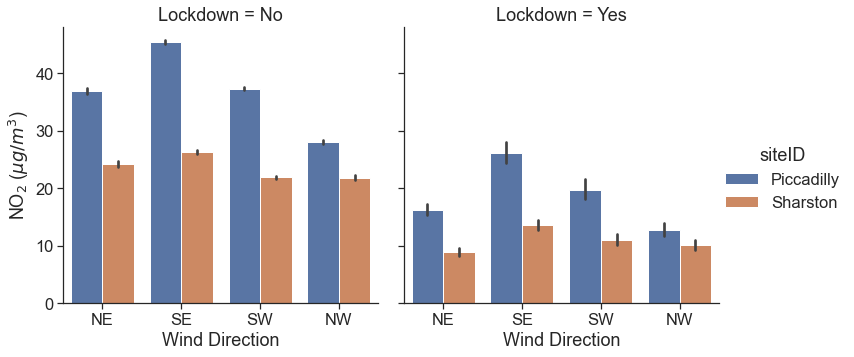

In [24]:
plt.figure(figsize=(10,5))
g = sns.catplot(data=all_data,x='Wind Direction',y='NO2',hue='siteID',col='Lockdown',kind='bar')
ax1, ax2 = g.axes[0]
ax1.set_ylabel('NO${_2}$ (${\mu g/m^{3}}$)')
plt.savefig('./FiguresEDA/NO2vsWindDirection')

In [25]:
picadilly['Wind Direction'] = pd.cut(picadilly['wd'].to_numpy(), bins = [0,90,180,270,360],right=True, labels =['NE','SE','SW','NW'])

In [26]:
ld_corr_comparison = shar_ld.corr()[['NO2']].iloc[1:,:].merge(pic_ld.corr()[['NO2']].iloc[1:,:],on=None, left_index=True,right_index=True)
ld_corr_comparison.columns =['Sharston_LD','Picadilly_LD']
ld_corr_comparison.merge(nld_corr_comparison,on=None, left_index=True,right_index=True).round(2)

,Sharston_LD,Picadilly_LD,Sharston,Picadilly
temp,-0.19,-0.30,-0.43,-0.38
ws,-0.40,-0.36,-0.38,-0.27
NE,-0.17,-0.15,0.01,-0.02
SE,0.22,0.32,0.14,0.31
SW,-0.02,0.01,-0.10,-0.06
NW,-0.08,-0.21,-0.04,-0.24
Volume,-0.10,0.05,0.13,0.20


In [28]:
months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct','Nov','Dec']

In [29]:
variable_names = {}
for i in range(12):
    variable_names['my_var_' + str(i)] = "wa"+str(i)

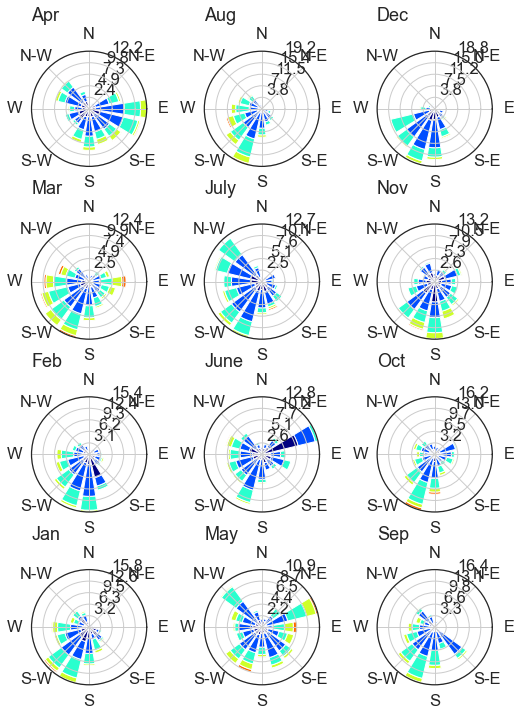

In [30]:
ys = np.arange(0,2.4,0.6)
xs = np.arange(0,1.2,0.4)
cords = []
for x in xs:
    for y in ys:
        cords.append([x,y])
count = 0
fig=plt.figure()
for var in variable_names:
    month = months[count]
    rect=[cords[count][0],cords[count][1],0.4,0.4] 
    var = WindroseAxes(fig, rect)
    fig.add_axes(var)
    var.bar(sharston.wd[sharston[month]==1],sharston.ws[sharston[month]==1],normed=True,opening=0.8,edgecolor='white')
    var.set_title(month,loc='left')
    count+=1
plt.show()


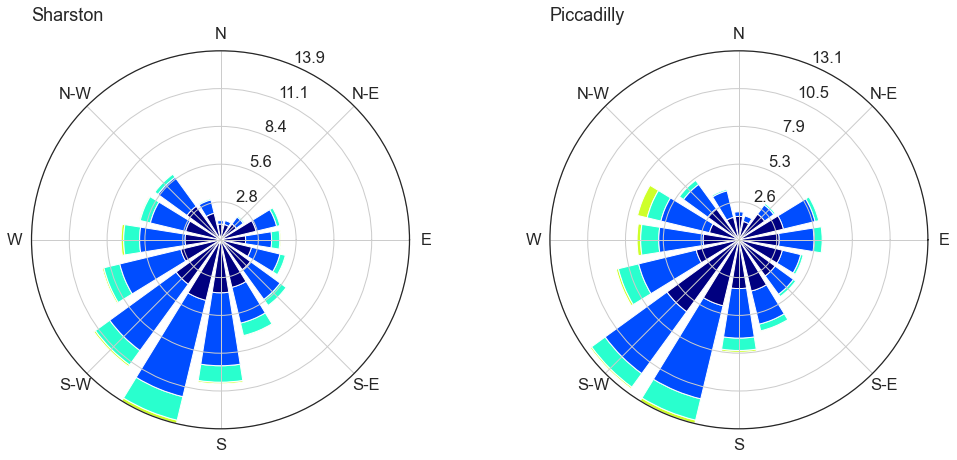

In [31]:
fig = plt.figure(figsize=(12,7))

rect=[0.,2.5,0.75,0.75] 
var = WindroseAxes(fig, rect)
fig.add_axes(var)
var.bar(sharston.wd,sharston.ws,normed=True,opening=0.8,edgecolor='white')
var.set_title('Sharston',loc='left')

rect2=[0.6,2.5,0.75,0.75] 
var2 = WindroseAxes(fig, rect2)
fig.add_axes(var2)
var2.bar(picadilly.wd,picadilly.ws,normed=True,opening=0.8,edgecolor='white')
var2.set_title('Piccadilly',loc='left')

fig.savefig('./FiguresEDA/windroses.png')

In [32]:
lockdown_data = all_data[all_data['Lockdown']=='Yes']
lockdown_data_pic = lockdown_data[lockdown_data['siteID'] == 'Piccadilly']
lockdown_data_shar = lockdown_data[lockdown_data['siteID'] == 'Sharston']

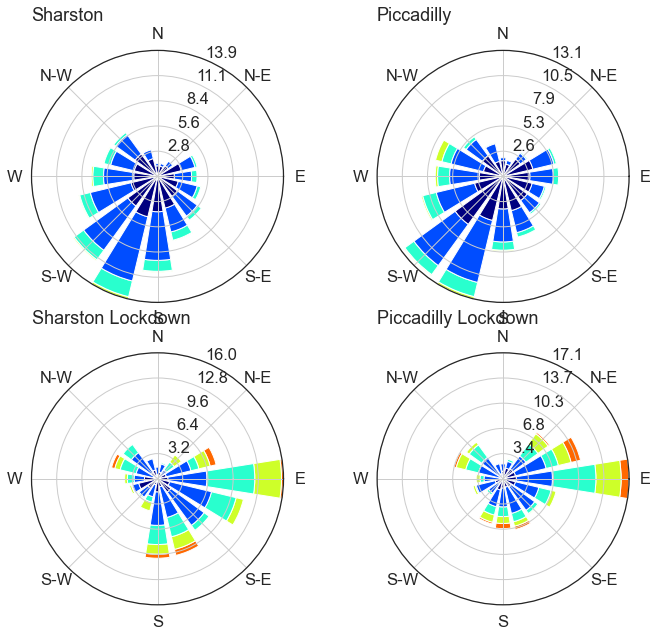

In [33]:
fig = plt.figure(figsize=(12,7))

rect=[0.,2.5,0.5,0.5] 
var = WindroseAxes(fig, rect)
fig.add_axes(var)
var.bar(sharston.wd,sharston.ws,normed=True,opening=0.8,edgecolor='white')
var.set_title('Sharston',loc='left')

rect2=[0.4,2.5,0.5,0.5] 
var2 = WindroseAxes(fig, rect2)
fig.add_axes(var2)
var2.bar(picadilly.wd,picadilly.ws,normed=True,opening=0.8,edgecolor='white')
var2.set_title('Piccadilly',loc='left')

rect3=[0.4,1.9,0.5,0.5] 
var3 = WindroseAxes(fig, rect3)
fig.add_axes(var3)
var3.bar(lockdown_data_pic.wd,lockdown_data_pic.ws,normed=True,opening=0.8,edgecolor='white')
var3.set_title('Piccadilly Lockdown',loc='left')

rect4=[0,1.9,0.5,0.5] 
var4 = WindroseAxes(fig, rect4)
fig.add_axes(var4)
var4.bar(lockdown_data_shar.wd,lockdown_data_shar.ws,normed=True,opening=0.8,edgecolor='white')
var4.set_title('Sharston Lockdown',loc='left')

fig.savefig('./FiguresEDA/windroses.png')

<Figure size 864x720 with 0 Axes>

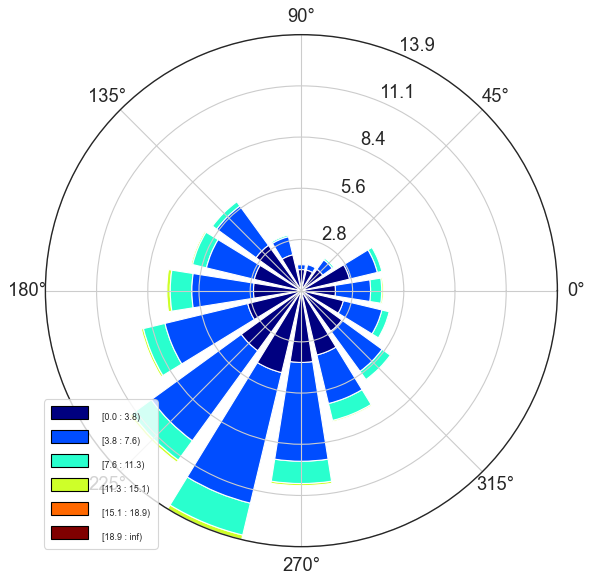

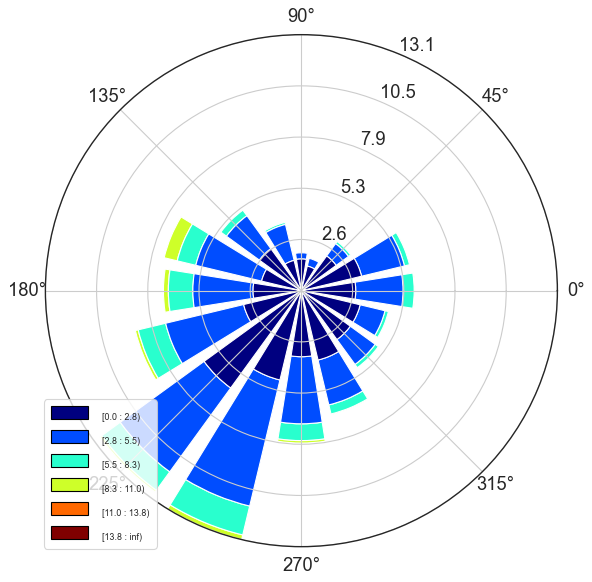

In [34]:
plt.figure(figsize=(12,10))

ax = WindroseAxes.from_ax()
ax.bar(sharston.wd,sharston.ws,normed=True,opening=0.8,edgecolor='white')
ax.set_legend()


ax = WindroseAxes.from_ax()
ax.bar(picadilly.wd,picadilly.ws,normed=True,opening=0.8,edgecolor='white')
ax.set_legend()

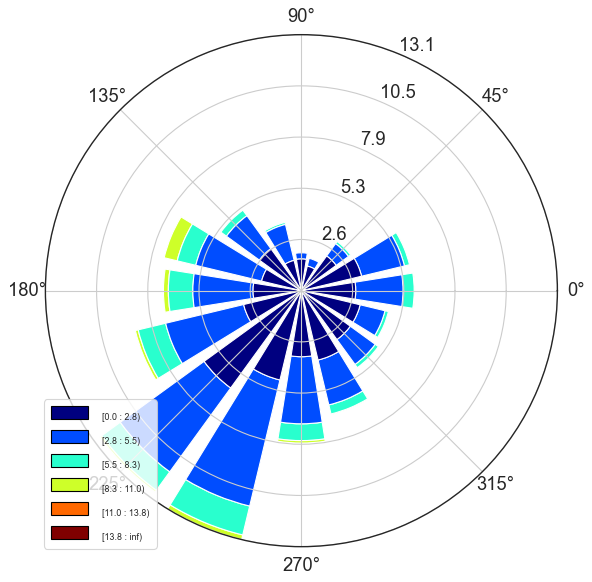

In [35]:
ax = WindroseAxes.from_ax()
ax.bar(picadilly.wd,picadilly.ws,normed=True,opening=0.8,edgecolor='white')
ax.set_legend()

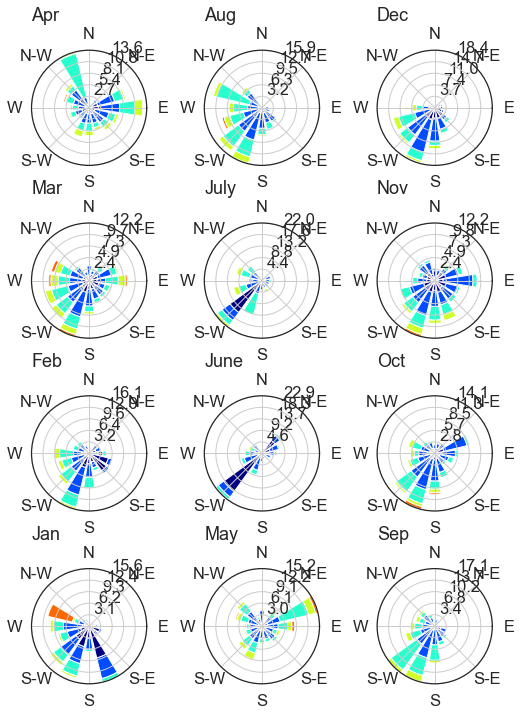

In [36]:
fig=plt.figure()
count=0
for var in variable_names:
    month = months[count]
    rect=[cords[count][0],cords[count][1],0.4,0.4] 
    var = WindroseAxes(fig, rect)
    fig.add_axes(var)
    var.bar(picadilly.wd[picadilly[month]==1],picadilly.ws[picadilly[month]==1],normed=True,opening=0.8,edgecolor='white')
    var.set_title(month,loc='left')
    count+=1
plt.show()

In [37]:
#stack previous year months which correspond to lockdown dates
years = ['2020','2019','2018','2017','2016']
sharston_comparison = []
for i in years:
    sharston_comparison.append(sharston[(sharston.index >= i+'-03-23') & (sharston.index<= i+'-06-23')])
sharston_comparison = pd.concat(sharston_comparison)


picadilly_comparison = []
for i in years:
    picadilly_comparison.append(picadilly[(picadilly.index >= i+'-03-23') & (picadilly.index<= i+'-06-23')])
picadilly_comparison = pd.concat(picadilly_comparison)

In [38]:
sharston_comparison['Lockdown'] = sharston_comparison['Lockdown'].replace({1:'Yes',0:'No'})
picadilly_comparison['Lockdown'] = picadilly_comparison['Lockdown'].replace({1:'Yes',0:'No'})

In [39]:
sharston_comparison['day_of_week'] = sharston_comparison['day_of_week'].replace({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
picadilly_comparison['day_of_week'] = picadilly_comparison['day_of_week'].replace({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})

In [40]:
sharston_comparison

,NO2,temp,ws,wd,Volume,Lockdown,hour,day_of_week,month,day,...,Aug,Sep,Oct,Nov,Dec,wd_1,wd_2,wd_3,wd_4,siteID
2020-03-23 00:00:00,8.23382,1.2,3.7,123.8,15,Yes,0,Mon,3,23,...,0,0,0,0,0,0,1,0,0,Sharston
2020-03-23 01:00:00,8.23382,1.2,3.7,123.8,16,Yes,1,Mon,3,23,...,0,0,0,0,0,0,1,0,0,Sharston
2020-03-23 02:00:00,8.94342,1.4,4.5,144.1,16,Yes,2,Mon,3,23,...,0,0,0,0,0,0,1,0,0,Sharston
2020-03-23 03:00:00,8.84776,0.8,3.8,147.5,14,Yes,3,Mon,3,23,...,0,0,0,0,0,0,1,0,0,Sharston
2020-03-23 04:00:00,16.24242,0.4,3.5,148.1,14,Yes,4,Mon,3,23,...,0,0,0,0,0,0,1,0,0,Sharston
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-22 19:00:00,12.15059,12.7,2.7,254.3,404,No,19,Thu,6,22,...,0,0,0,0,0,0,0,1,0,Sharston
2017-06-22 20:00:00,16.09656,11.5,2.2,215.8,303,No,20,Thu,6,22,...,0,0,0,0,0,0,0,1,0,Sharston
2017-06-22 21:00:00,22.48239,10.7,2.2,191.1,222,No,21,Thu,6,22,...,0,0,0,0,0,0,0,1,0,Sharston
2017-06-22 22:00:00,25.39226,10.3,3.1,203.2,134,No,22,Thu,6,22,...,0,0,0,0,0,0,0,1,0,Sharston


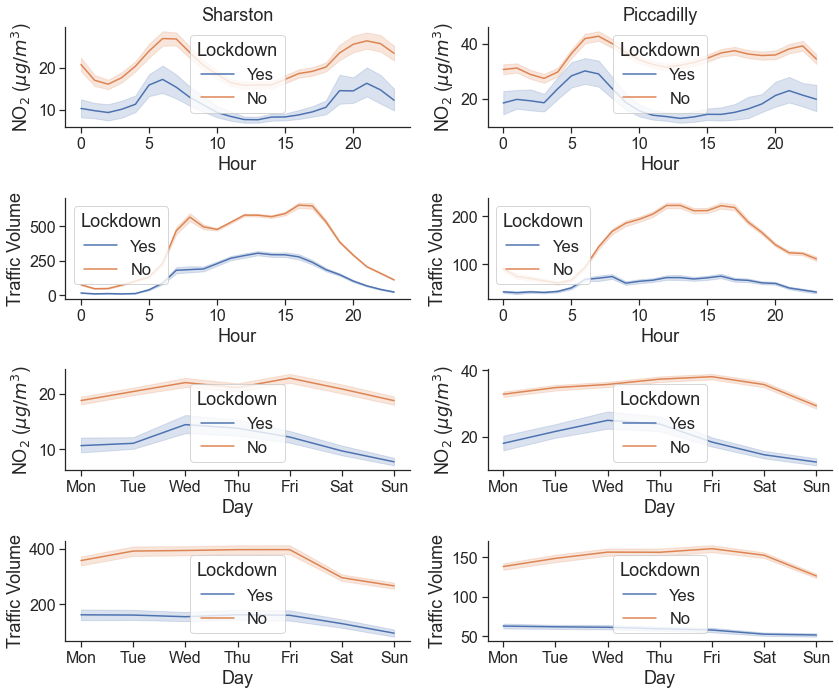

In [41]:
fontsize=18
tix = 16
plt.figure(figsize=(12,10))
plt.subplot(4,2,1)
sns.lineplot(x='hour',y='NO2',data=sharston_comparison,hue='Lockdown')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks (fontsize=tix)
plt.title ('Sharston', fontsize=fontsize)
plt.subplot(4,2,2)
sns.lineplot(x='hour',y='NO2',data=picadilly_comparison,hue='Lockdown')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks (fontsize=tix)
plt.title('Piccadilly', fontsize=fontsize)
plt.subplot(4,2,3)
sns.lineplot(x='hour',y='Volume',data=sharston_comparison,hue='Lockdown')
plt.ylabel('Traffic Volume', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks (fontsize=tix)
plt.subplot(4,2,4)
sns.lineplot(x='hour',y='Volume',data=picadilly_comparison,hue='Lockdown')
plt.ylabel('Traffic Volume', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks (fontsize=tix)
plt.subplot(4,2,5)
sns.lineplot(x='day_of_week',y='NO2',data=sharston_comparison,hue='Lockdown')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.xlabel('Day', fontsize=fontsize)
plt.subplot(4,2,6)
sns.lineplot(x='day_of_week',y='NO2',data=picadilly_comparison,hue='Lockdown')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.xlabel('Day', fontsize=fontsize)
plt.subplot(4,2,7)
sns.lineplot(x='day_of_week',y='Volume',data=sharston_comparison,hue='Lockdown')
plt.ylabel('Traffic Volume', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.xlabel('Day', fontsize=fontsize)
plt.subplot(4,2,8)
sns.lineplot(x='day_of_week',y='Volume',data=picadilly_comparison,hue='Lockdown')
plt.ylabel('Traffic Volume', fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.xlabel('Day', fontsize=fontsize)
plt.tight_layout()
plt.savefig('./FiguresEDA/LockdownvsNoLockDown.png')

TimeSeries

In [45]:
sharston.index = pd.to_datetime(sharston.index)
picadilly.index = pd.to_datetime(picadilly.index)

ts_sharston = pd.DataFrame(sharston[(sharston.index >= '2017-01-01') & (sharston.index <= '2019-12-31')][['NO2','Volume','ws','temp']])
ts_picadilly = pd.DataFrame(picadilly[(picadilly.index >= '2017-01-01') & (picadilly.index <= '2019-12-31')][['NO2','Volume','ws','temp']])

ts_sharston_daily = ts_sharston.resample('D').mean()
ts_sharston_monthly = ts_sharston.resample('M').mean()

ts_picadilly_daily = ts_picadilly.resample('D').mean()
ts_picadilly_monthly = ts_picadilly.resample('M').mean()


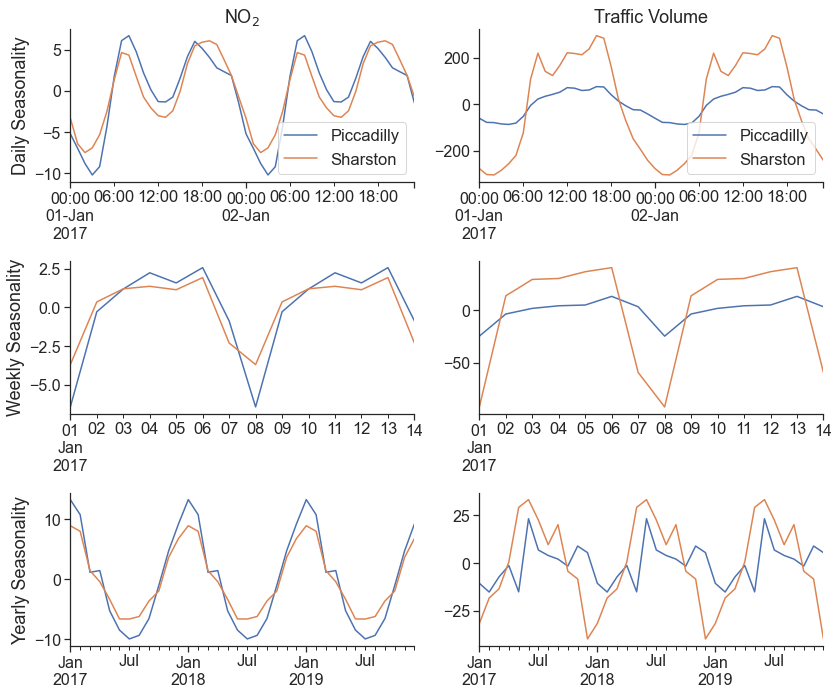

In [46]:
plt.figure(figsize=(12,10))
plt.subplot(3,2,1)
seasonal_decompose(ts_picadilly['NO2'], model='additive').seasonal[:48].plot(label='Piccadilly')
seasonal_decompose(ts_sharston['NO2'], model='additive').seasonal[:48].plot(label='Sharston')
plt.legend()
plt.ylabel('Daily Seasonality', fontsize=fontsize)
plt.title('NO${_2}$',fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.subplot(3,2,2)
seasonal_decompose(ts_picadilly['Volume'], model='additive').seasonal[:48].plot(label='Piccadilly')
seasonal_decompose(ts_sharston['Volume'], model='additive').seasonal[:48].plot(label='Sharston')
plt.title('Traffic Volume',fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.legend()
plt.subplot(3,2,3)
seasonal_decompose(ts_picadilly_daily['NO2'], model='additive').seasonal[:14].plot()
seasonal_decompose(ts_sharston_daily['NO2'], model='additive').seasonal[:14].plot()
plt.ylabel('Weekly Seasonality',fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.subplot(3,2,4)
seasonal_decompose(ts_picadilly_daily['Volume'], model='additive').seasonal[:14].plot()
seasonal_decompose(ts_sharston_daily['Volume'], model='additive').seasonal[:14].plot()
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.subplot(3,2,5)
seasonal_decompose(ts_picadilly_monthly['NO2'], model='additive').seasonal.plot()
seasonal_decompose(ts_sharston_monthly['NO2'], model='additive').seasonal.plot()
plt.ylabel('Yearly Seasonality',fontsize=fontsize)
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.subplot(3,2,6)
seasonal_decompose(ts_picadilly_monthly['Volume'], model='additive').seasonal.plot()
seasonal_decompose(ts_sharston_monthly['Volume'], model='additive').seasonal.plot()
plt.yticks (fontsize=tix)
plt.xticks (fontsize=tix)
plt.tight_layout()
plt.savefig('./FiguresEDA/seasonal_decomposition.png')